In [202]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib.font_manager as pltfont
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from scipy import spatial
from scipy.cluster import hierarchy
from pyhpo import Ontology, HPOSet
from HPO_functions import *
from clustering_functions import *
_ = Ontology()

# -------------------------------------------------------------------

### **Import pre-processed and filtered DECIPHER dataset**
- Remove patients with fewer than 4 associated HPO terms.

In [203]:
# Read DECIPHER output cs from DECIPHERDataHandling.ipynb & filter
decipherData = pd.read_csv('decipher_data_filtered.csv')

# Remove rows where the length of the list of HPO terms is less than 4.
decipherDataFiltered = decipherData[decipherData['hpo_terms_freq'] > 3]

# Find the number of patients remaining (399 patients)
num_rows = decipherDataFiltered.shape[0]
print(num_rows)

399


- Remove redundant HPO terms, identify IQR and approximately equalise the number of HPO terms per patient

In [204]:
# Identify outliers using the interquartile range for hpo_list
decipherDataFiltered['hpo_list'] = decipherDataFiltered['hpo_accessions'].str.split('|')
q1 = decipherDataFiltered['hpo_list'].apply(len).quantile(0.25)
q3 = decipherDataFiltered['hpo_list'].apply(len).quantile(0.75) 

# Calculate interquartile range and upper/lower outliers
iqr = q3 - q1
lowerOutlier = q1 - 1.5 * iqr
upperOutlier = q3 + 1.5 * iqr

# Remove HPO terms that are less relevant to clustering (such as modifier and obsolete terms) 
decipherDataFiltered = decipherDataFiltered.reset_index(drop=True)
decipherDataFiltered['hpo_set'] = decipherDataFiltered['hpo_list'].apply(HPOSet.from_queries)
decipherDataFiltered['hpo_set'] = decipherDataFiltered['hpo_set'].apply(HPOSet.remove_modifier)
decipherDataFiltered['hpo_set'] = decipherDataFiltered['hpo_set'].apply(HPOSet.replace_obsolete)
decipherDataFiltered['hpo_set'] = decipherDataFiltered['hpo_set'].apply(HPOSet.child_nodes)
decipherDataFiltered['hpo_list'] = decipherDataFiltered['hpo_set'].apply(get_hpo_list)

# Select patients that have a greater number of HPO terms than the upper outlier
decipher_upperOutliers = decipherDataFiltered[decipherDataFiltered['hpo_list'].apply(len) > upperOutlier]

# Filter by retaining HPO terms with the highest IC (information content) up to the upper outlier number of HPO terms
decipher_upperOutliers['filtered_hpo_list'] = decipher_upperOutliers['hpo_set'].apply(filter_highest_ic_terms, max_number_of_terms=int(upperOutlier), list_or_object='list')
decipher_upperOutliers['filtered_hpo_set'] = decipher_upperOutliers['filtered_hpo_list'].apply(HPOSet.from_queries)
merge = decipherDataFiltered.merge(decipher_upperOutliers, how='left', left_index=True, right_index=True)
decipherDataFiltered['filtered_hpo_list'] = merge['filtered_hpo_list'].fillna(merge['hpo_list_x'])
decipherDataFiltered['filtered_hpo_set'] = merge['filtered_hpo_set'].fillna(merge['hpo_set_x'])
decipherDataFiltered = decipherDataFiltered.reset_index()

- Compute similarity between patients

In [205]:
# Convert the pyhpo similarity function into a vectorized function
vsim = np.vectorize(HPOSet.similarity)

# Create two matrices that correspond with the pairs to compare in the next step
x, y = np.meshgrid(decipherDataFiltered['filtered_hpo_set'], decipherDataFiltered['filtered_hpo_set'])

# Semantic similarity is computed via the Graphic method, which checks for the sum of the IC of the common ancestors divided by the sum of the IC of the combined (union) parents of both terms (1 = identical terms) 
# The 'funSimAvg' method combines term-term similarity scores into set-set similarity scores
method, combine = 'graphic', 'funSimAvg'

# Run HPOSet.similarity on the whole of the two matrices
result = vsim(x, y, kind='omim', method=method, combine=combine)

- Create distance matrix and dendrogram

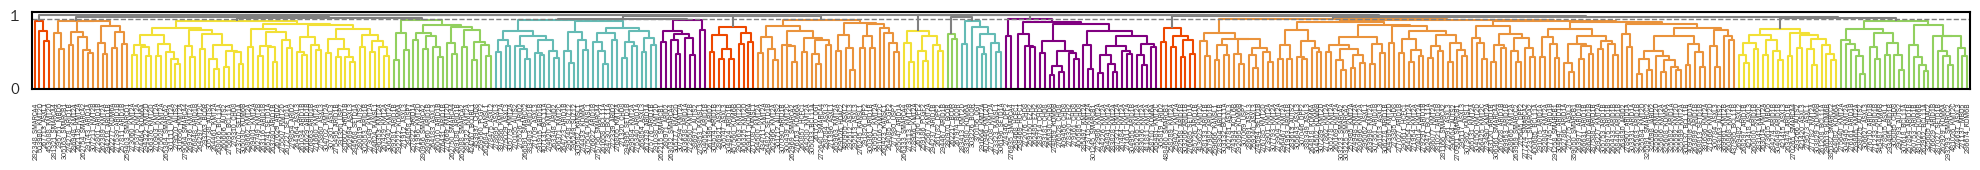

In [209]:
# Create patient identifiers
decipherDataFiltered['patient_id'] = (decipherDataFiltered["# patient_id"]).astype(str) + "_" +  (decipherDataFiltered["gene"]).astype(str) 
decipherDataFiltered.index = decipherDataFiltered['patient_id']

# Set methods to use
affinity, linkageMethod = 'precomputed', 'complete'

# Convert result to pandas dataframe and add header and index.
graphicHPOsim = pd.DataFrame(result, index=decipherDataFiltered.index, columns=decipherDataFiltered.index)

# Convert the similarity matrix to a distance matrix: now 0 equals zero distance between terms, therefore identical terms = 0 -> This will be the input for the hierarchical cluster analysis.
graphicHPOdistance = pd.DataFrame(np.max(result)-(np.array(result)), index=decipherDataFiltered.index, columns=decipherDataFiltered.index)

# Convert distance matrix to distance vector.
distance1D = spatial.distance.squareform(np.max(result)-(np.array(result)), force='tovector', checks=False)

# Calculate hierarchical linkage from the distance vector.
linkage = hierarchy.linkage(distance1D, method = linkageMethod)

# Plot dendrogram without heatmap
customParams = {"axes.edgecolor": 'black', "axes.linewidth": 1.5}
plt.figure(figsize=(25, 1))
sns.set_theme(style= 'whitegrid', font_scale=1, font="Franklin Gothic Book", rc=customParams)
hierarchy.set_link_color_palette(['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'])
hierarchy.dendrogram(linkage, labels=graphicHPOsim.index, color_threshold=0.95, above_threshold_color='grey', leaf_font_size=5)
plt.axhline(y=0.95, c='grey', lw=1, linestyle='dashed')
plt.xticks(rotation=90)
plt.grid()
plt.show()

- From the dendrogram, it was decided that n=12 clusters, using a threshold of 0.95, was ideal to try and identify specific phenotypic clusters

In [210]:
# Perform clustering
clustering = AgglomerativeClustering(n_clusters=12, affinity=affinity, linkage=linkageMethod).fit(graphicHPOdistance)

# Add information for each patient
labels = clustering.labels_ + 1
decipherDataFiltered['cluster'] = labels
decipherDataFiltered['filtered_hpo_list_length'] = decipherDataFiltered['filtered_hpo_list'].apply(len)

- The following graphs were made to check that clusters are not largely driven by HPO term frequency
- While there is still a large range in the number of terms per patient, no one cluster appears to be driven by HPO frequency

<Figure size 640x480 with 0 Axes>

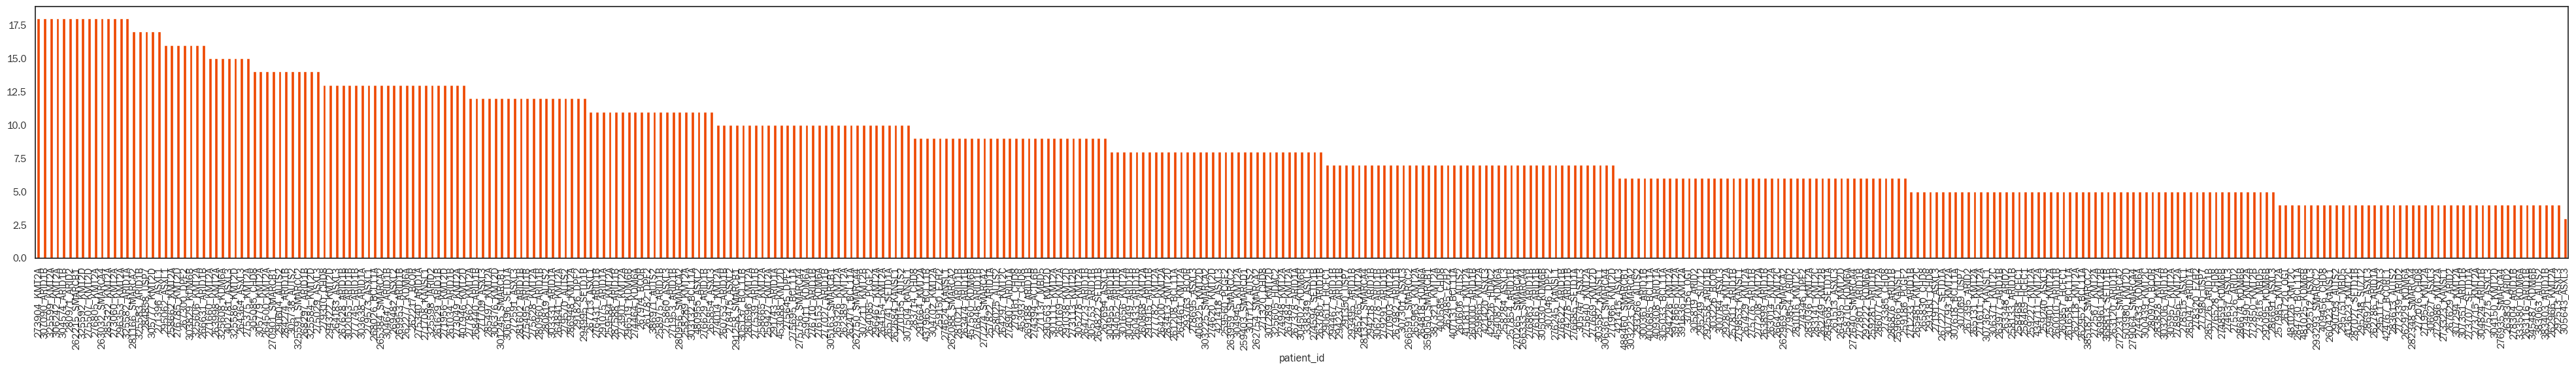

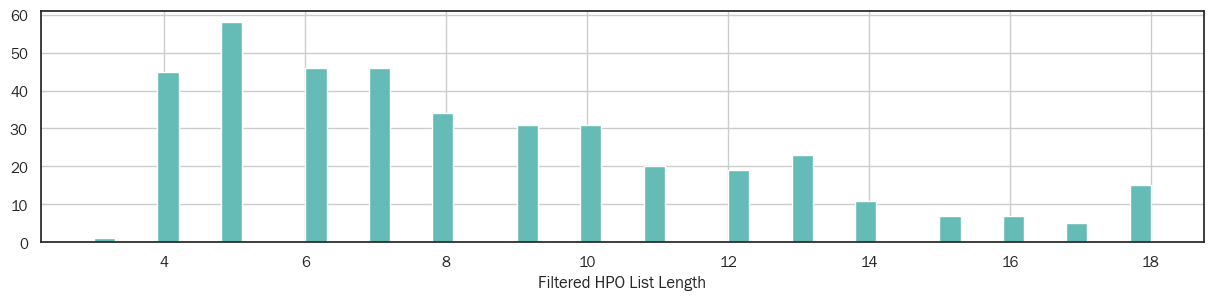

<Figure size 10000x300 with 0 Axes>

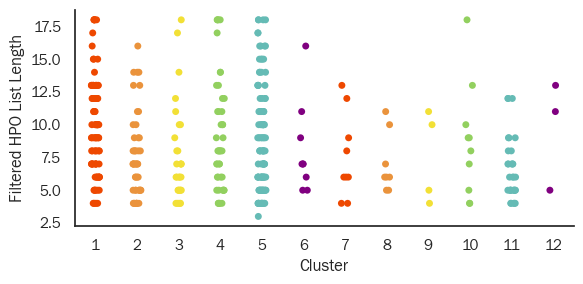

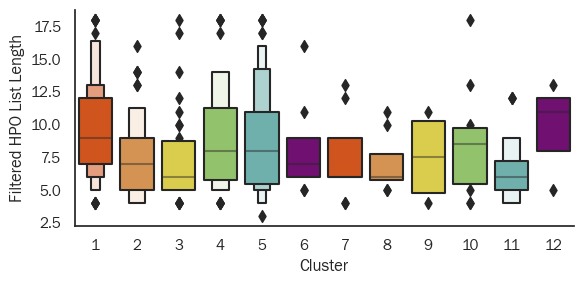

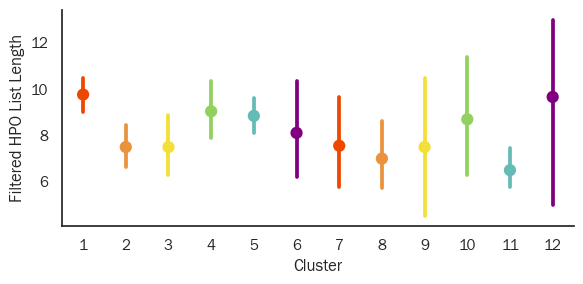

In [211]:
# Order decipher by filtered_hpo_list_length.
decipherDataFiltered = decipherDataFiltered.sort_values(by='filtered_hpo_list_length', ascending=False)

# Plot a bar graph with the length of filtered_hpo_list per gene
plt.figure()
sns.set_theme(style='white', font="Franklin Gothic Book",font_scale=1, palette=['#ee4800'])
decipherDataFiltered.plot.bar(x='patient_id', y='filtered_hpo_list_length', rot=90, figsize=(50, 5), legend=False)

# Plot a histogram 
plt.figure(figsize=(15, 3))
sns.set_theme(style='white', font="Franklin Gothic Book",font_scale=1, palette=['#65bbb5'])
decipherDataFiltered['filtered_hpo_list_length'].hist(bins=50)
plt.xlabel('Filtered HPO List Length')

# Plot a categorical plots of filtered_hpo_list_length and the cluster number
plt.figure(figsize=(100, 3))
sns.set_theme(style='white', font="Franklin Gothic Book", font_scale=1)
sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipherDataFiltered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2)
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipherDataFiltered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2, kind='boxen')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipherDataFiltered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2, kind='point')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')

# Group the df by cluster and count the number of patients in each cluster.
decipherClusterCount = decipherDataFiltered.groupby('cluster').count()

- Clusters do not appear to be substantially driven by HPO term frequency

# -------------------------------------------------------------------

### **Phenotypic comparison across the 12 clusters**
- Separate patients into different cluster dataframes

In [212]:
# Split dataframe by cluster, starting with largest cluster
decipherCluster1 = decipherDataFiltered[decipherDataFiltered['cluster'] == 5] 
decipherCluster2 = decipherDataFiltered[decipherDataFiltered['cluster'] == 1]
decipherCluster3 = decipherDataFiltered[decipherDataFiltered['cluster'] == 2]
decipherCluster4 = decipherDataFiltered[decipherDataFiltered['cluster'] == 4]
decipherCluster5 = decipherDataFiltered[decipherDataFiltered['cluster'] == 11]
decipherCluster6 = decipherDataFiltered[decipherDataFiltered['cluster'] == 3]
decipherCluster7 = decipherDataFiltered[decipherDataFiltered['cluster'] == 10]
decipherCluster8 = decipherDataFiltered[decipherDataFiltered['cluster'] == 6]
decipherCluster9 = decipherDataFiltered[decipherDataFiltered['cluster'] == 7]
decipherCluster10 = decipherDataFiltered[decipherDataFiltered['cluster'] == 8]
decipherCluster11 = decipherDataFiltered[decipherDataFiltered['cluster'] == 9]
decipherCluster12 = decipherDataFiltered[decipherDataFiltered['cluster'] == 12]

# Get frequency of patients in each cluster
clusterFreqs = [(len(decipherCluster1)), (len(decipherCluster2)), (len(decipherCluster3)), (len(decipherCluster4)), (len(decipherCluster5)), (len(decipherCluster6)),
                 (len(decipherCluster7)), (len(decipherCluster8)), (len(decipherCluster9)), (len(decipherCluster10)), (len(decipherCluster11)), (len(decipherCluster12))]

# Identify the HPO terms across all clusters
allHPOterms = set()
decipherDataFiltered['propagated_terms'].str.split("|").apply(allHPOterms.update)
freqHPOterms = len(list(allHPOterms))

- Get the frequency & percentage occurance of each HPO term in each cluster
- Identify which terms are significantly increased in each cluster when compared to all other clusters as a group

In [213]:
clusterFreq = pd.DataFrame({'hpo_term': list(get_HPOID_cluster_freq(decipherCluster1, allHPOterms).keys()), 
                              'cluster_1_freq': list(get_HPOID_cluster_freq(decipherCluster1, allHPOterms).values()), 
                              'cluster_2_freq': list(get_HPOID_cluster_freq(decipherCluster2, allHPOterms).values()), 
                              'cluster_3_freq': list(get_HPOID_cluster_freq(decipherCluster3, allHPOterms).values()),
                              'cluster_4_freq': list(get_HPOID_cluster_freq(decipherCluster4, allHPOterms).values()), 
                              'cluster_5_freq': list(get_HPOID_cluster_freq(decipherCluster5, allHPOterms).values()), 
                              'cluster_6_freq': list(get_HPOID_cluster_freq(decipherCluster6, allHPOterms).values()), 
                              'cluster_7_freq': list(get_HPOID_cluster_freq(decipherCluster7, allHPOterms).values()), 
                              'cluster_8_freq': list(get_HPOID_cluster_freq(decipherCluster8, allHPOterms).values()), 
                              'cluster_9_freq': list(get_HPOID_cluster_freq(decipherCluster9, allHPOterms).values()),
                              'cluster_10_freq': list(get_HPOID_cluster_freq(decipherCluster10, allHPOterms).values()), 
                              'cluster_11_freq': list(get_HPOID_cluster_freq(decipherCluster11, allHPOterms).values()), 
                              'cluster_12_freq': list(get_HPOID_cluster_freq(decipherCluster12, allHPOterms).values())})

# Calculate percentages
for i in range(1,13):
    clusterFreq["cluster_"+str(i)+"_percent"] = (clusterFreq["cluster_"+str(i)+"_freq"])/clusterFreqs[i-1]

# Get HPO Terms increased in each cluster
for i in range(1,13):
    get_sigincreased_HPOTerms_cluster(i, clusterFreq, clusterFreqs, total_clusters=12)

# -------------------------------------------------------------------

### **Visualise phenotypic differences across the 12 clusters**
- Filter dataframe to prepare data for visualisation

In [214]:
# Get HPO terms present in at least 10% of patients in at least one cluster
clusterFreq_subset = clusterFreq[(clusterFreq['cluster_1_percent']>0.1) | (clusterFreq['cluster_2_percent']>0.1)|(clusterFreq['cluster_3_percent']>0.1)| 
                                     (clusterFreq['cluster_4_percent']>0.1) | (clusterFreq['cluster_5_percent']>0.1)|(clusterFreq['cluster_6_percent']>0.1)| 
                                     (clusterFreq['cluster_7_percent']>0.1) | (clusterFreq['cluster_8_percent']>0.1)|(clusterFreq['cluster_9_percent']>0.1)| 
                                     (clusterFreq['cluster_10_percent']>0.1)| (clusterFreq['cluster_11_percent']>0.1)|(clusterFreq['cluster_12_percent']>0.1)]

# Get p-values in each cluster for each HPO term
clusterFreqPval = clusterFreq_subset[["hpo_term", "cluster_1_sig_indicate", "cluster_2_sig_indicate", "cluster_3_sig_indicate", "cluster_4_sig_indicate", 
                                            "cluster_5_sig_indicate", "cluster_6_sig_indicate", "cluster_7_sig_indicate", "cluster_8_sig_indicate", 
                                            "cluster_9_sig_indicate", "cluster_10_sig_indicate", "cluster_11_sig_indicate", "cluster_12_sig_indicate"]]

# Get percentage occurance in each cluster for each HPO term
clusterFreqPhenotypes = clusterFreq_subset[["hpo_term", "cluster_1_percent", "cluster_2_percent", "cluster_3_percent", "cluster_4_percent", 
                                                 "cluster_5_percent", "cluster_6_percent", "cluster_7_percent", "cluster_8_percent", 
                                                 "cluster_9_percent", "cluster_10_percent", "cluster_11_percent", "cluster_12_percent"]]

# Rename for visualisation
clusterFreqPhenotypes = clusterFreqPhenotypes.rename(columns={'cluster_1_percent':f'Cluster 1 (n={clusterFreqs[0]})', 'cluster_2_percent':f'Cluster 2 (n={clusterFreqs[1]})', 'cluster_3_percent':f'Cluster 3 (n={clusterFreqs[2]})', 
                                                            'cluster_4_percent':f'Cluster 4 (n={clusterFreqs[3]})', 'cluster_5_percent':f'Cluster 5 (n={clusterFreqs[4]})', 'cluster_6_percent':f'Cluster 6 (n={clusterFreqs[5]})', 
                                                            'cluster_7_percent':f'Cluster 7 (n={clusterFreqs[6]})', 'cluster_8_percent':f'Cluster 8 (n={clusterFreqs[7]})', 'cluster_9_percent':f'Cluster 9 (n={clusterFreqs[8]})', 
                                                            'cluster_10_percent':f'Cluster 10 (n={clusterFreqs[9]})', 'cluster_11_percent':f'Cluster 11 (n={clusterFreqs[10]})', 'cluster_12_percent':f'Cluster 12 (n={clusterFreqs[11]})'})

# Reset indices
clusterFreqPhenotypes = clusterFreqPhenotypes.set_index("hpo_term")
clusterFreqPval = clusterFreqPval.set_index("hpo_term")

- Visualise the prevelance of the 5 identified top-level HPO terms across the 12 clusters

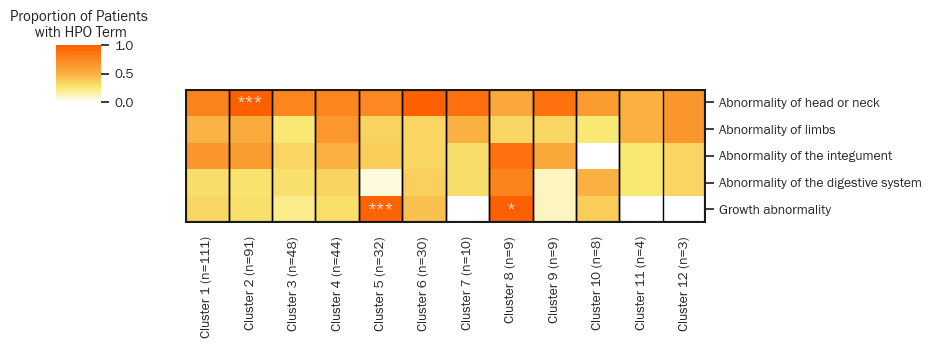

In [215]:
# Filter for top-level HPO terms list
topLevelPhenotypesList = ("Abnormality of head or neck",  "Abnormality of limbs", "Abnormality of the integument", "Abnormality of the digestive system", "Growth abnormality")
clusterFreqPhenotypesFiltered  = clusterFreqPhenotypes[clusterFreqPhenotypes.index.isin(topLevelPhenotypesList)]
clusterFreqPhenotypesFiltered.index = (pd.Categorical(clusterFreqPhenotypesFiltered.index, categories=topLevelPhenotypesList, ordered=True))
clusterFreqPhenotypesFiltered = clusterFreqPhenotypesFiltered.sort_index()

clusterFreqPvalFiltered  = clusterFreqPval[clusterFreqPval.index.isin(topLevelPhenotypesList)]
clusterFreqPvalFiltered.index = pd.Categorical(clusterFreqPvalFiltered.index, categories=topLevelPhenotypesList, ordered=True)
clusterFreqPvalFiltered = clusterFreqPvalFiltered.sort_index()

# Plot heatmap
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'white'), (0.25, '#f9e873'), (0.5, '#fab142'), (1, '#fe6000')], N=256)

sns.set_style("white")
sns.set_theme(font_scale=0.9, font="Franklin Gothic Book")
heatmap = sns.clustermap(clusterFreqPhenotypesFiltered, cmap=cmap, method="ward", annot=clusterFreqPvalFiltered, figsize=(9, 3.15), 
                         row_cluster=False, col_cluster=False, fmt="", cbar_kws={'ticks':[0, 0.50, 1], 'orientation':'vertical'})
heatmap.ax_cbar.set_title('Proportion of Patients\n with HPO Term')

ax = heatmap.ax_heatmap
ax.add_patch(Rectangle((0,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((1,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((2,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((3,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((4,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((5,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((6,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((7,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((8,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((9,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((10,0 ), 1, 200, fill=False, edgecolor='black', lw=1))

ax.axhline(y = 0, color='k',linewidth = 3) 
ax.axhline(y = 5, color = 'k', linewidth = 3) 
ax.axvline(x = 0, color = 'k', linewidth = 3) 
ax.axvline(x = 12, color = 'k', linewidth = 3)

plt.savefig('cluster_heatmap_top_level.png', dpi=600)
plt.show()

- Visualise key differences between the 12 clusters

['Neurodevelopmental abnormality', 'Neurological speech impairment']
['Abnormality of the face', 'Abnormal nasal morphology']
['Behavioral abnormality', 'Autistic behavior']
['Abnormal eye physiology', 'Abnormality of the eye']
['Abnormality of body height', 'Growth abnormality']
['Abnormal skull morphology', 'Abnormality of skull size']
['Abnormal muscle tone', 'Abnormal muscle tone']
['Constipation', 'Postnatal growth retardation']
['Ventricular septal defect', 'Abnormal cardiac ventricle morphology']
['Abnormality of male external genitalia', 'Abnormal external genitalia']
['Abnormal heart morphology', 'Abnormality of cardiovascular system morphology']
['Microphthalmia', 'Cataract']


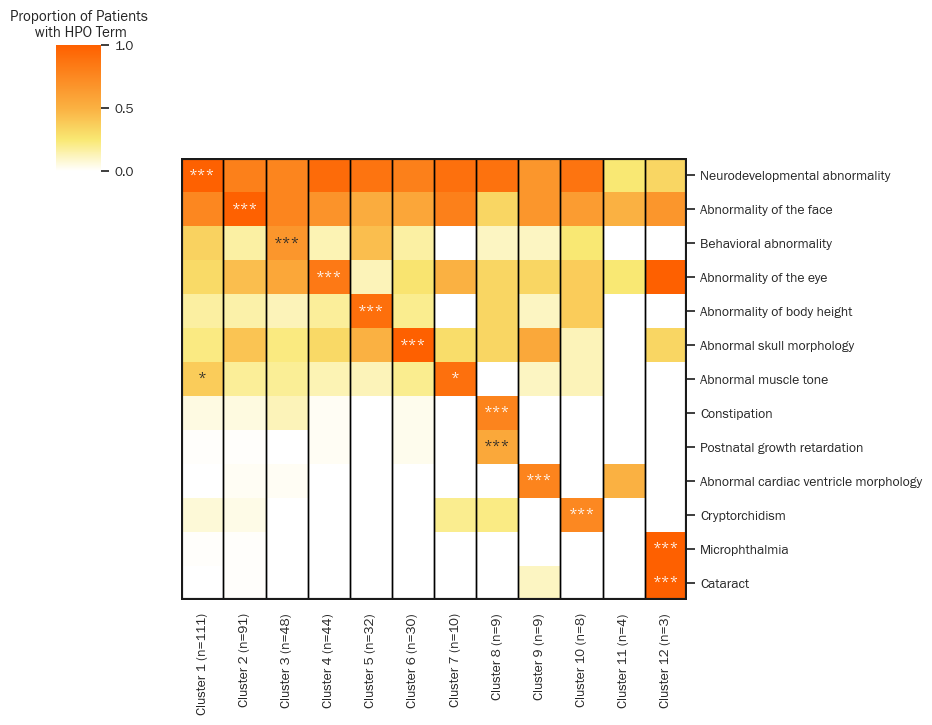

In [216]:
# Get all significant terms across all groups
allSigTerms = pd.DataFrame()
topPhenotypes = []
for i in range(1,13):

    # Get significant terms for each cluster
    clusterFreqSig = clusterFreq[clusterFreq['cluster_'+str(i)+'_adj_p_value'] < 0.05]
    clusterFreqSig = clusterFreqSig[clusterFreqSig['cluster_'+str(i)+'_OR'] > 1]
    allSigTerms = pd.concat([allSigTerms, clusterFreqSig], axis=0)

allSigTerms.to_csv('allSigTerms.csv')

# Get top 2 HPO terms for each cluster by smallest p-value
topPhenotypes = []
for i in range(1,13):

    # Get 2 most significant terms for each cluster
    topCluster = allSigTerms.sort_values(by='cluster_'+str(i)+'_p_value', ascending=True)['hpo_term'].head(n=2)
    print(list(topCluster))
    topPhenotypes.append(topCluster)

# Flatten list
topPhenotypesFlatList = [item for sublist in topPhenotypes for item in sublist]

# Simplify heatmap: manually remove terms that are child terms of the other term identified in each group
topPhenotypesFlatList.remove('Neurological speech impairment') # 'Neurodevelopmental abnormality' retained
topPhenotypesFlatList.remove('Abnormal nasal morphology') # 'Abnormality of the face'retained
topPhenotypesFlatList.remove('Autistic behavior') # 'Behavioural abnormality' retained
topPhenotypesFlatList.remove('Abnormal eye physiology') # 'Abnormality of the eye' retained
topPhenotypesFlatList.remove('Abnormality of skull size') # 'Abnormal skull morphology' retained
topPhenotypesFlatList.remove('Ventricular septal defect') # 'Abnormal cardiac ventricle morphology' retained

# Remove duplicated terms (significant in two clusters)
topPhenotypesFlatList.remove('Abnormal muscle tone') 

# Remove top-level terms that are present in the above heatmap
topPhenotypesFlatList.remove('Growth abnormality')

# Remove/replace parent terms that reflect a single child term
topPhenotypesFlatList.remove('Abnormal external genitalia')
topPhenotypesFlatList.remove('Abnormality of male external genitalia')
topPhenotypesFlatList.insert(10, 'Cryptorchidism')

# Remove terms that are not significant in relevant cluster
topPhenotypesFlatList.remove('Abnormal heart morphology') # Top term for cluster 11 but not significant
topPhenotypesFlatList.remove('Abnormality of cardiovascular system morphology')

# Filter using HPO terms list
clusterFreqPhenotypesFiltered  = clusterFreqPhenotypes[clusterFreqPhenotypes.index.isin(topPhenotypesFlatList)]
clusterFreqPhenotypesFiltered.index = pd.Categorical(clusterFreqPhenotypesFiltered.index, categories=topPhenotypesFlatList, ordered=True)
clusterFreqPhenotypesFiltered = clusterFreqPhenotypesFiltered.sort_index()

clusterFreqPvalFiltered  = clusterFreqPval[clusterFreqPval.index.isin(topPhenotypesFlatList)]
clusterFreqPvalFiltered.index = pd.Categorical(clusterFreqPvalFiltered.index, categories=topPhenotypesFlatList, ordered=True)
clusterFreqPvalFiltered = clusterFreqPvalFiltered.sort_index()

# Plot heatmap
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'white'), (0.25, '#f9e873'), (0.5, '#fab142'), (1, '#fe6000')], N=256)
sns.set_style("white")
sns.set_theme(font_scale=0.9, font="Franklin Gothic Book")
heatmap = sns.clustermap(clusterFreqPhenotypesFiltered, cmap=cmap, method="ward", annot=clusterFreqPvalFiltered, figsize=(9, 7), 
                         row_cluster=False, col_cluster=False, fmt="", cbar_kws={'ticks':[0, 0.50, 1], 'orientation':'vertical'})
heatmap.ax_cbar.set_title('Proportion of Patients\n with HPO Term')

ax = heatmap.ax_heatmap
ax.add_patch(Rectangle((0,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((1,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((2,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((3,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((4,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((5,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((6,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((7,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((8,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((9,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((10,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((11,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((12,0 ), 1, 200, fill=False, edgecolor='black', lw=1))

ax.axhline(y = 0, color='k',linewidth = 3) 
ax.axhline(y = 13, color = 'k', linewidth = 3) 
ax.axvline(x = 0, color = 'k', linewidth = 3) 
ax.axvline(x = 12, color = 'k', linewidth = 3)

plt.savefig('cluster_heatmap.png', dpi=600)
plt.show()

# -------------------------------------------------------------------